In [ ]:
import yfinance as yf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Fetch data for AAPL stock
data = yf.download('AAPL', start='2018-01-01', end='2023-01-01')

# Copy 'Close' and 'Volume' to df
df = data[['Close', 'Volume']].copy()

# Calculate Bollinger Bands
df['SMA'] = df['Close'].rolling(window=20).mean()
df['stddev'] = df['Close'].rolling(window=20).std()
df['UpperBand'] = df['SMA'] + (df['stddev'] * 2)
df['LowerBand'] = df['SMA'] - (df['stddev'] * 2)

# Scale the 'Close', 'Volume', 'UpperBand', and 'LowerBand'
scaler = MinMaxScaler(feature_range=(0,1))
df['Scaled_Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))
df['Scaled_Volume'] = scaler.fit_transform(df['Volume'].values.reshape(-1,1))
df['Scaled_UpperBand'] = scaler.fit_transform(df['UpperBand'].values.reshape(-1,1))
df['Scaled_LowerBand'] = scaler.fit_transform(df['LowerBand'].values.reshape(-1,1))


[*********************100%***********************]  1 of 1 completed


In [ ]:
import yfinance as yf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.wrappers.scikit_learn import KerasRegressor
from keras.regularizers import l2
import pandas as pd
import numpy as np

# Fetch data for AAPL stock
data = yf.download('AAPL', start='2018-01-01', end='2023-01-01')

# Copy 'Close' and 'Volume' to df
df = data[['Close', 'Volume']].copy()

# Calculate Bollinger Bands
df['SMA'] = df['Close'].rolling(window=20).mean()
df['stddev'] = df['Close'].rolling(window=20).std()
df['UpperBand'] = df['SMA'] + (df['stddev'] * 2)
df['LowerBand'] = df['SMA'] - (df['stddev'] * 2)

# Scale the 'Close', 'Volume', 'UpperBand', and 'LowerBand'
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = pd.DataFrame(index=df.index)
scaled_df['Scaled_Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))
scaled_df['Scaled_Volume'] = scaler.fit_transform(df['Volume'].values.reshape(-1,1))
scaled_df['Scaled_UpperBand'] = scaler.fit_transform(df['UpperBand'].values.reshape(-1,1))
scaled_df['Scaled_LowerBand'] = scaler.fit_transform(df['LowerBand'].values.reshape(-1,1))

# Drop rows with NaN values
scaled_df.dropna(inplace=True)

X = []
y = []
for i in range(60, len(scaled_df)):
    X.append(scaled_df.iloc[i-60:i].values)
    y.append(scaled_df['Scaled_Close'].iloc[i])

X, y = np.array(X), np.array(y)

# Define the LSTM model in a function for cross-validation
def create_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))  # Add dropout with a probability of 0.2
    model.add(LSTM(units=50, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))  # Add dropout with a probability of 0.2
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Use KerasRegressor to wrap the model for use with scikit-learn
regressor = KerasRegressor(build_fn=create_model, epochs=50, batch_size=64, verbose=1)

# Perform cross-validation
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor.fit(X_train, y_train)

# Threshold for buying/selling
threshold = 0.01  # arbitrary
# Make predictions
predicted_price = regressor.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price.reshape(-1,1))  # descale to original range

# Calculate the true future close prices
true_future_price = df['Close'].iloc[len(X_train):]

# Buy whenever the model predicts an increase greater than the threshold, sell when it predicts a decrease greater than the threshold
diff_predicted_price = np.diff(predicted_price.reshape(-1))
signals = np.concatenate([(diff_predicted_price > threshold), [False]])

# Calculate the profit from this strategy
buy_price = None
profits = []
for signal, price in zip(signals, true_future_price):
    if signal and buy_price is None:  # buy
        buy_price = price
    elif not signal and buy_price is not None:  # sell
        profits.append(price - buy_price)
        buy_price = None
# Set a transaction cost
transaction_cost = 0.005  # For example, 0.5%

profits = []
for signal, price in zip(signals, true_future_price):
    if signal and buy_price is None:  # buy
        buy_price = price * (1 + transaction_cost)  # Increase the buy price by the transaction cost
    elif not signal and buy_price is not None:  # sell
        sell_price = price * (1 - transaction_cost)  # Decrease the sell price by the transaction cost
        profits.append(sell_price - buy_price)
        buy_price = None
# Calculate the total profit from the trading strategy
total_profit = sum(profits)
print(f'Total profit: {total_profit}')

# Calculate the model's accuracy
accuracy = np.mean((np.diff(true_future_price.values) > threshold) == signals[:-1])
print(f'Accuracy: {accuracy}')



[*********************100%***********************]  1 of 1 completed


<ipython-input-14-7067cdc41146>:54: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_model, epochs=50, batch_size=64, verbose=1)


Epoch 1/50
4/4 [==============================] - 5s 61ms/step - loss: 0.8590
Epoch 2/50
4/4 [==============================] - 0s 61ms/step - loss: 0.7931
Epoch 3/50
4/4 [==============================] - 0s 61ms/step - loss: 0.7322
Epoch 4/50
4/4 [==============================] - 0s 60ms/step - loss: 0.6760
Epoch 5/50
4/4 [==============================] - 0s 63ms/step - loss: 0.6227
Epoch 6/50
4/4 [==============================] - 0s 62ms/step - loss: 0.5729
Epoch 7/50
4/4 [==============================] - 0s 60ms/step - loss: 0.5267
Epoch 8/50
4/4 [==============================] - 0s 62ms/step - loss: 0.4834
Epoch 9/50
4/4 [==============================] - 0s 61ms/step - loss: 0.4434
Epoch 10/50
4/4 [==============================] - 0s 60ms/step - loss: 0.4064
Epoch 11/50
4/4 [==============================] - 0s 60ms/step - loss: 0.3720
Epoch 12/50
4/4 [==============================] - 0s 65ms/step - loss: 0.3403
Epoch 13/50
4/4 [==============================] - 0s 64ms/st

<ipython-input-14-7067cdc41146>:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.mean((np.diff(true_future_price.values) > threshold) == signals[:-1])


In [ ]:
# Calculate the profit from this strategy
buy_price = None
profits = []
for signal, price in zip(signals, true_future_price):
    if signal and buy_price is None:  # buy
        buy_price = price
    elif not signal and buy_price is not None:  # sell
        profit = ((price - buy_price) / buy_price) * 100  # profit in percentage
        profits.append(profit)
        buy_price = None

# Calculate the total profit percentage from the trading strategy
total_profit_percentage = sum(profits)
print(f'Total profit percentage: {total_profit_percentage}')


Total profit percentage: 23.01156333056346


My bot


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
import yfinance as yf

# Fetch data for AAPL stock
data = yf.download('AAPL', start='2018-01-01', end='2023-01-01')

# Copy 'Close' and 'Volume' to df
df = data[['Close', 'Volume']].copy()

# Calculate Bollinger Bands
df['SMA'] = df['Close'].rolling(window=20).mean()
df['stddev'] = df['Close'].rolling(window=20).std()
df['UpperBand'] = df['SMA'] + (df['stddev'] * 2)
df['LowerBand'] = df['SMA'] - (df['stddev'] * 2)

# Scale the 'Close', 'Volume', 'UpperBand', and 'LowerBand'
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = pd.DataFrame(index=df.index)
scaled_df['Scaled_Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))
scaled_df['Scaled_Volume'] = scaler.fit_transform(df['Volume'].values.reshape(-1,1))
scaled_df['Scaled_UpperBand'] = scaler.fit_transform(df['UpperBand'].values.reshape(-1,1))
scaled_df['Scaled_LowerBand'] = scaler.fit_transform(df['LowerBand'].values.reshape(-1,1))

# Drop rows with NaN values
scaled_df.dropna(inplace=True)

# Prepare training data
X = []
y = []
for i in range(60, len(scaled_df)):
    X.append(scaled_df.iloc[i-60:i].values)
    y.append(scaled_df['Scaled_Close'].iloc[i])

X, y = np.array(X), np.array(y)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model
def create_model(dropout_rate=0.0, regularization_rate=0.0):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(regularization_rate)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=50, kernel_regularizer=l2(regularization_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Create a KerasRegressor and perform a grid search to find the best hyperparameters
model = KerasRegressor(build_fn=create_model, verbose=1)
param_grid = {
    'dropout_rate': [0.2, 0.3],
        'regularization_rate': [0.01, 0.02],
    'epochs': [50, 100],
    'batch_size': [64, 128]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Train the LSTM model with the best found hyperparameters
best_dropout = grid_result.best_params_['dropout_rate']
best_regularization = grid_result.best_params_['regularization_rate']
best_epochs = grid_result.best_params_['epochs']
best_batch_size = grid_result.best_params_['batch_size']

model = create_model(best_dropout, best_regularization)
model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=1)

# Use the model to make predictions
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)  # descale to original range

# Calculate the true future close prices
true_future_price = df['Close'].iloc[len(X_train):]

# Buy whenever the model predicts an increase, sell when it predicts a decrease
signals = np.diff(predicted_price.reshape(-1)) > 0
# Adding the last prediction as `False` to match signals length with prices
signals = np.concatenate([signals, [False]])

# Calculate the profit from this strategy, considering transaction costs of 0.1%
transaction_cost_rate = 0.001  # 0.1% per trade
buy_price = None
profits = []
for signal, price in zip(signals, true_future_price):
    if signal and buy_price is None:  # buy
        buy_price = price
    elif not signal and buy_price is not None:  # sell
        profit = price - buy_price - (buy_price + price) * transaction_cost_rate / 2  # account for transaction costs
        profits.append(profit)
        buy_price = None

# Calculate the total profit from the trading strategy
total_profit = sum(profits)
print(f'Total profit: {total_profit}')

# Calculate the model's accuracy
accuracy = np.mean((np.diff(true_future_price.values) > 0) == signals[:-1])
print(f'Accuracy: {accuracy}')



[*********************100%***********************]  1 of 1 completed


<ipython-input-1-dcdd80125a2f>:60: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=1)


Epoch 1/50
12/12 [==============================] - 15s 18ms/step - loss: 0.8469
Epoch 2/50
12/12 [==============================] - 0s 13ms/step - loss: 0.6643
Epoch 3/50
12/12 [==============================] - 0s 13ms/step - loss: 0.5338
Epoch 4/50
12/12 [==============================] - 0s 15ms/step - loss: 0.4269
Epoch 5/50
12/12 [==============================] - 0s 14ms/step - loss: 0.3402
Epoch 6/50
12/12 [==============================] - 0s 18ms/step - loss: 0.2706
Epoch 7/50
12/12 [==============================] - 0s 14ms/step - loss: 0.2152
Epoch 8/50
12/12 [==============================] - 0s 14ms/step - loss: 0.1708
Epoch 9/50
12/12 [==============================] - 0s 10ms/step - loss: 0.1357
Epoch 10/50
12/12 [==============================] - 0s 9ms/step - loss: 0.1082
Epoch 11/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0867
Epoch 12/50
12/12 [==============================] - 0s 8ms/step - loss: 0.0701
Epoch 13/50
12/12 [====================

3/3 [==============================] - 1s 8ms/step - loss: 0.0129
Epoch 1/50
12/12 [==============================] - 4s 12ms/step - loss: 1.6255
Epoch 2/50
12/12 [==============================] - 0s 12ms/step - loss: 1.2897
Epoch 3/50
12/12 [==============================] - 0s 9ms/step - loss: 1.0191
Epoch 4/50
12/12 [==============================] - 0s 9ms/step - loss: 0.7992
Epoch 5/50
12/12 [==============================] - 0s 8ms/step - loss: 0.6230
Epoch 6/50
12/12 [==============================] - 0s 8ms/step - loss: 0.4834
Epoch 7/50
12/12 [==============================] - 0s 8ms/step - loss: 0.3727
Epoch 8/50
12/12 [==============================] - 0s 8ms/step - loss: 0.2869
Epoch 9/50
12/12 [==============================] - 0s 9ms/step - loss: 0.2200
Epoch 10/50
12/12 [==============================] - 0s 8ms/step - loss: 0.1692
Epoch 11/50
12/12 [==============================] - 0s 19ms/step - loss: 0.1295
Epoch 12/50
12/12 [==============================] - 0s 14ms

Streaming output truncated to the last 5000 lines.
Epoch 17/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1603
Epoch 18/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1444
Epoch 19/100
6/6 [==============================] - 0s 13ms/step - loss: 0.1309
Epoch 20/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1181
Epoch 21/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1068
Epoch 22/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0972
Epoch 23/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0885
Epoch 24/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0801
Epoch 25/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0733
Epoch 26/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0672
Epoch 27/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0610
Epoch 28/100
6/6 [==============================] - 0s 11ms/step - lo

<ipython-input-1-dcdd80125a2f>:112: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.mean((np.diff(true_future_price.values) > 0) == signals[:-1])


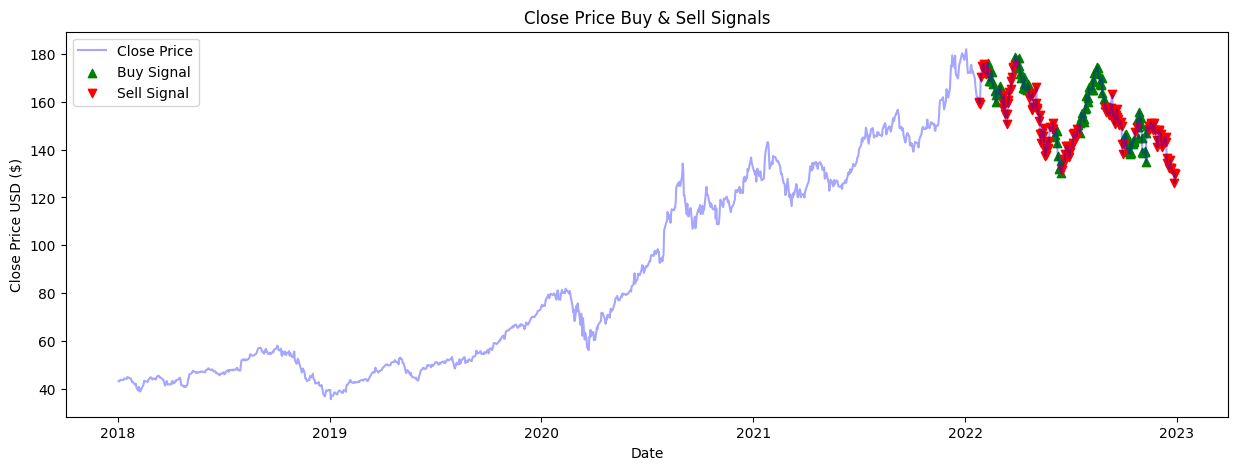

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert index to datetime for plotting
df.index = pd.to_datetime(df.index)

true_future_price = df['Close'].iloc[-len(X_test):]

buy_signals = true_future_price[signals]
sell_signals = true_future_price[np.logical_not(signals)]


plt.figure(figsize=(15,5))
plt.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.35)
plt.scatter(buy_signals.index, buy_signals, color='green', label='Buy Signal', marker='^', alpha=1)
plt.scatter(sell_signals.index, sell_signals, color='red', label='Sell Signal', marker='v', alpha=1)
plt.title('Close Price Buy & Sell Signals')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()


# updated bot

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit

def calculate_RSI(data, window):
    delta = data.diff().dropna()
    up = delta * 0
    down = up.copy()
    up[delta > 0] = delta[delta > 0]
    down[delta < 0] = -delta[delta < 0]
    avg_gain = up.ewm(com=window - 1, adjust=False).mean()
    avg_loss = down.ewm(com=window - 1, adjust=False).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_MACD(data, short_window, long_window):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    MACD = short_ema - long_ema
    signal_line = MACD.ewm(span=9, adjust=False).mean()
    return MACD, signal_line

# Fetch data for AAPL stock
data = yf.download('AAPL', start='2018-01-01', end='2023-01-01')

# Copy 'Close' and 'Volume' to df
df = data[['Close', 'Volume']].copy()

# Calculate Bollinger Bands
df['SMA'] = df['Close'].rolling(window=20).mean()
df['stddev'] = df['Close'].rolling(window=20).std()
df['UpperBand'] = df['SMA'] + (df['stddev'] * 2)
df['LowerBand'] = df['SMA'] - (df['stddev'] * 2)

# Calculate RSI and MACD
df['RSI'] = calculate_RSI(df['Close'], window=14)
df['MACD'], df['Signal Line'] = calculate_MACD(df['Close'], short_window=12, long_window=26)


# Scale the 'Close', 'Volume', 'UpperBand', and 'LowerBand'
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = pd.DataFrame(index=df.index)
scaled_df['Scaled_Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))
scaled_df['Scaled_Volume'] = scaler.fit_transform(df['Volume'].values.reshape(-1,1))
scaled_df['Scaled_UpperBand'] = scaler.fit_transform(df['UpperBand'].values.reshape(-1,1))
scaled_df['Scaled_LowerBand'] = scaler.fit_transform(df['LowerBand'].values.reshape(-1,1))
scaled_df['Scaled_RSI'] = scaler.fit_transform(df['RSI'].values.reshape(-1,1))
scaled_df['Scaled_MACD'] = scaler.fit_transform(df['MACD'].values.reshape(-1,1))
scaled_df['Scaled_Signal_Line'] = scaler.fit_transform(df['Signal Line'].values.reshape(-1,1))


# Drop rows with NaN values
scaled_df.dropna(inplace=True)

# Prepare training data
# Prepare training data
X = []
y = []
for i in range(60, len(scaled_df)):
    X.append(scaled_df.iloc[i-60:i].values)
    y.append(scaled_df['Scaled_Close'].iloc[i])

X, y = np.array(X), np.array(y)

# Set parameters for rolling window validation
window_size = 60
n_splits = 5

# Initialize TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Define the LSTM model
    def create_model(dropout_rate=0.0, regularization_rate=0.0):
      model = Sequential()
      model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(regularization_rate)))
      model.add(Dropout(dropout_rate))
      model.add(LSTM(units=50, kernel_regularizer=l2(regularization_rate)))
      model.add(Dropout(dropout_rate))
      model.add(Dense(1))
      model.compile(loss='mean_squared_error', optimizer='adam')
      return model

    # Create a KerasRegressor and perform a grid search to find the best hyperparameters
    model = KerasRegressor(build_fn=create_model, verbose=1)
    param_grid = {
        'dropout_rate': [0.2, 0.3],
        'regularization_rate': [0.01, 0.02],
        'epochs': [50, 100],
        'batch_size': [64, 128]
    }

    grid = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_result = grid.fit(X_train, y_train)

    # Summarize results
    print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

    profits_per_split = []
    accuracies_per_split = []

    # Initialize the starting point for training
    train_start = 0

    # Train the LSTM model with the best found hyperparameters
    best_dropout = grid_result.best_params_['dropout_rate']
    best_regularization = grid_result.best_params_['regularization_rate']
    best_epochs = grid_result.best_params_['epochs']
    best_batch_size = grid_result.best_params_['batch_size']

    for train_end in range(window_size, len(X) - window_size, window_size):
        X_train, y_train = X[train_start:train_end], y[train_start:train_end]
        X_test, y_test = X[train_end:train_end + window_size], y[train_end:train_end + window_size]

        # Update train_start for the next iteration
        train_start = train_end

        # Fit the model
        model = create_model(best_dropout, best_regularization)
        model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=1)

        # Make predictions and get trading signals
        predicted_price = model.predict(X_test)
        predicted_price = scaler.inverse_transform(predicted_price)
        true_future_price = df['Close'].iloc[train_end:train_end + window_size]
        signals = np.diff(predicted_price.reshape(-1)) > 0
        signals = np.concatenate([signals, [False]])

        # Calculate profits and record them
        transaction_cost_rate = 0.001
        buy_price = None
        profits = []
        for signal, price in zip(signals, true_future_price):
            if signal and buy_price is None:  # buy
                buy_price = price
            elif not signal and buy_price is not None:  # sell
                profit = price - buy_price - (buy_price + price) * transaction_cost_rate / 2
                profits.append(profit)
                buy_price = None
        total_profit = sum(profits)
        print(f'Split profit: {total_profit}')
        profits_per_split.append(total_profit)

        # Calculate accuracies and record them
        accuracy = np.mean((np.diff(true_future_price.values) > 0) == signals[:-1])
        print(f'Split accuracy: {accuracy}')
        accuracies_per_split.append(accuracy)

# Calculate and print average profit and accuracy
average_profit = sum(profits_per_split) / len(profits_per_split)
average_accuracy = sum(accuracies_per_split) / len(accuracies_per_split)
print(f'Average profit: {average_profit}')
print(f'Average accuracy: {average_accuracy}')



[*********************100%***********************]  1 of 1 completed


<ipython-input-2-cb0a9aa6f4aa>:95: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=1)


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 12ms/step - loss: 0.2764
Epoch 32/100
2/2 [==============================] - 0s 13ms/step - loss: 0.2643
Epoch 33/100
2/2 [==============================] - 0s 13ms/step - loss: 0.2526
Epoch 34/100
2/2 [==============================] - 0s 12ms/step - loss: 0.2415
Epoch 35/100
2/2 [==============================] - 0s 13ms/step - loss: 0.2309
Epoch 36/100
2/2 [==============================] - 0s 13ms/step - loss: 0.2206
Epoch 37/100
2/2 [==============================] - 0s 12ms/step - loss: 0.2108
Epoch 38/100
2/2 [==============================] - 0s 16ms/step - loss: 0.2013
Epoch 39/100
2/2 [==============================] - 0s 12ms/step - loss: 0.1923
Epoch 40/100
2/2 [==============================] - 0s 13ms/step - loss: 0.1836
Epoch 41/100
2/2 [==============================] - 0s 12ms/step - loss: 0.1754
Epoch 42/100
2/2 [==============================] - 0s 12ms/step - loss: 0.1674
Ep

<ipython-input-2-cb0a9aa6f4aa>:95: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=1)


Streaming output truncated to the last 5000 lines.
3/3 [==============================] - 0s 13ms/step - loss: 0.1338
Epoch 32/100
3/3 [==============================] - 0s 12ms/step - loss: 0.1245
Epoch 33/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1158
Epoch 34/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1077
Epoch 35/100
3/3 [==============================] - 0s 12ms/step - loss: 0.1000
Epoch 36/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0929
Epoch 37/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0862
Epoch 38/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0800
Epoch 39/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0742
Epoch 40/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0687
Epoch 41/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0637
Epoch 42/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0590
Ep

<ipython-input-2-cb0a9aa6f4aa>:95: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=1)


Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 11ms/step - loss: 0.0620
Epoch 32/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0562
Epoch 33/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0508
Epoch 34/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0459
Epoch 35/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0413
Epoch 36/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0373
Epoch 37/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0336
Epoch 38/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0304
Epoch 39/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0275
Epoch 40/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0247
Epoch 41/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0223
Epoch 42/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0202
Ep

<ipython-input-2-cb0a9aa6f4aa>:95: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=1)


Streaming output truncated to the last 5000 lines.
5/5 [==============================] - 0s 11ms/step - loss: 0.0439
Epoch 32/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0394
Epoch 33/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0357
Epoch 34/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0321
Epoch 35/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0294
Epoch 36/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0265
Epoch 37/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0242
Epoch 38/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0221
Epoch 39/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0201
Epoch 40/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0184
Epoch 41/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0170
Epoch 42/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0154
Ep

<ipython-input-2-cb0a9aa6f4aa>:95: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=1)


Streaming output truncated to the last 5000 lines.
7/7 [==============================] - 0s 14ms/step - loss: 0.0194
Epoch 33/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0177
Epoch 34/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0163
Epoch 35/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0149
Epoch 36/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0140
Epoch 37/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0132
Epoch 38/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0120
Epoch 39/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0116
Epoch 40/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0105
Epoch 41/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0102
Epoch 42/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0100
Epoch 43/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0091
Ep

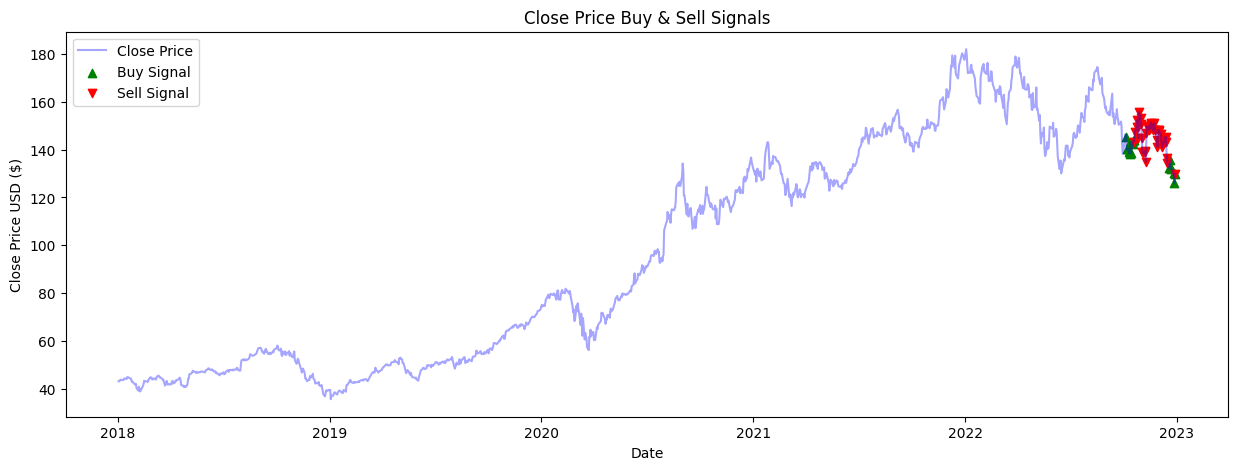

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert index to datetime for plotting
df.index = pd.to_datetime(df.index)

true_future_price = df['Close'].iloc[-len(X_test):]

buy_signals = true_future_price[signals]
sell_signals = true_future_price[np.logical_not(signals)]


plt.figure(figsize=(15,5))
plt.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.35)
plt.scatter(buy_signals.index, buy_signals, color='green', label='Buy Signal', marker='^', alpha=1)
plt.scatter(sell_signals.index, sell_signals, color='red', label='Sell Signal', marker='v', alpha=1)
plt.title('Close Price Buy & Sell Signals')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()


# adding More models

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


def calculate_RSI(data, window):
    delta = data.diff().dropna()
    up = delta * 0
    down = up.copy()
    up[delta > 0] = delta[delta > 0]
    down[delta < 0] = -delta[delta < 0]
    avg_gain = up.ewm(com=window - 1, adjust=False).mean()
    avg_loss = down.ewm(com=window - 1, adjust=False).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_MACD(data, short_window, long_window):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    MACD = short_ema - long_ema
    signal_line = MACD.ewm(span=9, adjust=False).mean()
    return MACD, signal_line

# Fetch data for AAPL stock
data = yf.download('AAPL', start='2018-01-01', end='2023-01-01')

# Copy 'Close' and 'Volume' to df
df = data[['Close', 'Volume']].copy()

# Calculate Bollinger Bands
df['SMA'] = df['Close'].rolling(window=20).mean()
df['stddev'] = df['Close'].rolling(window=20).std()
df['UpperBand'] = df['SMA'] + (df['stddev'] * 2)
df['LowerBand'] = df['SMA'] - (df['stddev'] * 2)

# Calculate RSI and MACD
df['RSI'] = calculate_RSI(df['Close'], window=14)
df['MACD'], df['Signal Line'] = calculate_MACD(df['Close'], short_window=12, long_window=26)


# Scale the 'Close', 'Volume', 'UpperBand', and 'LowerBand'
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = pd.DataFrame(index=df.index)
scaled_df['Scaled_Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))
scaled_df['Scaled_Volume'] = scaler.fit_transform(df['Volume'].values.reshape(-1,1))
scaled_df['Scaled_UpperBand'] = scaler.fit_transform(df['UpperBand'].values.reshape(-1,1))
scaled_df['Scaled_LowerBand'] = scaler.fit_transform(df['LowerBand'].values.reshape(-1,1))
scaled_df['Scaled_RSI'] = scaler.fit_transform(df['RSI'].values.reshape(-1,1))
scaled_df['Scaled_MACD'] = scaler.fit_transform(df['MACD'].values.reshape(-1,1))
scaled_df['Scaled_Signal_Line'] = scaler.fit_transform(df['Signal Line'].values.reshape(-1,1))


# Drop rows with NaN values
scaled_df.dropna(inplace=True)

# Prepare training data
# Prepare training data
X = []
y = []
for i in range(60, len(scaled_df)):
    X.append(scaled_df.iloc[i-60:i].values)
    y.append(scaled_df['Scaled_Close'].iloc[i])

X, y = np.array(X), np.array(y)

# Set parameters for rolling window validation
window_size = 60
n_splits = 5

# Initialize TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_splits)
transaction_cost_rate = 0.001  # cost of transaction

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    # Define the models
    def create_lstm_model(dropout_rate=0.0, regularization_rate=0.0):
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(regularization_rate)))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units=50, kernel_regularizer=l2(regularization_rate)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model

    def create_rf_model():
        model = RandomForestRegressor(n_estimators=100)
        return model

    def create_svm_model():
        model = SVR()
        return model

    # Convert the 3D data to 2D for Random Forest and SVM
    X_flat = np.reshape(X, (X.shape[0], -1))

    profits_per_split = []
    accuracies_per_split = []

    # Initialize the starting point for training
    train_start = 0

    # Define grid search parameters
    param_grid = {
        'dropout_rate': [0.2, 0.3],
        'regularization_rate': [0.01, 0.02],
        'epochs': [50, 100],
        'batch_size': [64, 128]
    }

    # Create a KerasRegressor and perform a grid search to find the best hyperparameters
    model = KerasRegressor(build_fn=create_lstm_model, verbose=1)

    grid = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_result = grid.fit(X_train, y_train)

    # Summarize results
    print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

    # Train the models with the best hyperparameters
    best_dropout = grid_result.best_params_['dropout_rate']
    best_regularization = grid_result.best_params_['regularization_rate']
    best_epochs = grid_result
    best_epochs = grid_result.best_params_['epochs']
    best_batch_size = grid_result.best_params_['batch_size']


    # Add parentheses when creating rf and svm models
    models = [create_lstm_model(best_dropout, best_regularization), create_rf_model(), create_svm_model()]

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Reshape X_train and X_test for non LSTM models
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_test_flat = X_test.reshape(X_test.shape[0], -1)

        # Train the models
        trained_models = []
        for model_func in models:
            model = model_func
            if isinstance(model, Sequential):
                model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size)
            else:
                model.fit(X_train_flat, y_train)
            trained_models.append(model)

        # Make predictions and combine them
        predictions = []
        for model in trained_models:
            if isinstance(model, Sequential):
                predictions.append(model.predict(X_test))
            else:
                predictions.append(model.predict(X_test_flat).reshape(-1, 1))

        # Average the predictions
        final_prediction = np.mean(predictions, axis=0)

        # Calculate profits and record them
        signals = np.diff(final_prediction.reshape(-1)) > 0
        signals = np.concatenate([signals, [False]])

        profits = []
        buy_price = None
        for signal, price in zip(signals, y_test):
            if signal and buy_price is None:  # buy
                buy_price = price
            elif not signal and buy_price is not None:  # sell
                profit = price - buy_price - (buy_price + price) * transaction_cost_rate / 2
                profits.append(profit)
                buy_price = None

    total_profit = sum(profits)
    profits_per_split.append(total_profit)
    print(f'Split profit: {total_profit}')

    # Calculate accuracies and record them
    accuracy = np.mean((np.diff(y_test) > 0) == signals[:-1])
    accuracies_per_split.append(accuracy)
    print(f'Split accuracy: {accuracy}')

# Calculate and print average profit and accuracy
average_profit = sum(profits_per_split) / len(profits_per_split)
average_accuracy = sum(accuracies_per_split) / len(accuracies_per_split)
print(f'Average profit: {average_profit}')
print(f'Average accuracy: {average_accuracy}')

[*********************100%***********************]  1 of 1 completed


<ipython-input-1-e4eb2fd25968>:125: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model, verbose=1)


Epoch 1/50
3/3 [==============================] - 23s 248ms/step - loss: 0.9438
Epoch 2/50
3/3 [==============================] - 1s 215ms/step - loss: 0.8925
Epoch 3/50
3/3 [==============================] - 1s 284ms/step - loss: 0.8424
Epoch 4/50
3/3 [==============================] - 1s 235ms/step - loss: 0.7945
Epoch 5/50
3/3 [==============================] - 1s 225ms/step - loss: 0.7488
Epoch 6/50
3/3 [==============================] - 1s 235ms/step - loss: 0.7062
Epoch 7/50
3/3 [==============================] - 1s 237ms/step - loss: 0.6645
Epoch 8/50
3/3 [==============================] - 1s 279ms/step - loss: 0.6250
Epoch 9/50
3/3 [==============================] - 1s 251ms/step - loss: 0.5877
Epoch 10/50
3/3 [==============================] - 1s 310ms/step - loss: 0.5521
Epoch 11/50
3/3 [==============================] - 1s 316ms/step - loss: 0.5184
Epoch 12/50
3/3 [==============================] - 1s 353ms/step - loss: 0.4864
Epoch 13/50
3/3 [==============================]

1/1 [==============================] - 1s 918ms/step - loss: 0.0339
Epoch 1/50
3/3 [==============================] - 5s 91ms/step - loss: 1.8317
Epoch 2/50
3/3 [==============================] - 0s 80ms/step - loss: 1.7278
Epoch 3/50
3/3 [==============================] - 0s 80ms/step - loss: 1.6291
Epoch 4/50
3/3 [==============================] - 0s 137ms/step - loss: 1.5352
Epoch 5/50
3/3 [==============================] - 0s 145ms/step - loss: 1.4451
Epoch 6/50
3/3 [==============================] - 0s 137ms/step - loss: 1.3597
Epoch 7/50
3/3 [==============================] - 0s 134ms/step - loss: 1.2778
Epoch 8/50
3/3 [==============================] - 0s 134ms/step - loss: 1.2001
Epoch 9/50
3/3 [==============================] - 0s 131ms/step - loss: 1.1262
Epoch 10/50
3/3 [==============================] - 0s 140ms/step - loss: 1.0567
Epoch 11/50
3/3 [==============================] - 0s 95ms/step - loss: 0.9905
Epoch 12/50
3/3 [==============================] - 0s 82ms/step -

Streaming output truncated to the last 5000 lines.
Epoch 17/100
2/2 [==============================] - 0s 88ms/step - loss: 0.9803
Epoch 18/100
2/2 [==============================] - 0s 91ms/step - loss: 0.9389
Epoch 19/100
2/2 [==============================] - 0s 91ms/step - loss: 0.8991
Epoch 20/100
2/2 [==============================] - 0s 94ms/step - loss: 0.8607
Epoch 21/100
2/2 [==============================] - 0s 90ms/step - loss: 0.8239
Epoch 22/100
2/2 [==============================] - 0s 91ms/step - loss: 0.7884
Epoch 23/100
2/2 [==============================] - 0s 138ms/step - loss: 0.7543
Epoch 24/100
2/2 [==============================] - 0s 125ms/step - loss: 0.7217
Epoch 25/100
2/2 [==============================] - 0s 121ms/step - loss: 0.6901
Epoch 26/100
2/2 [==============================] - 0s 140ms/step - loss: 0.6598
Epoch 27/100
2/2 [==============================] - 0s 120ms/step - loss: 0.6309
Epoch 28/100
2/2 [==============================] - 0s 128ms/ste

<ipython-input-1-e4eb2fd25968>:125: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model, verbose=1)


Streaming output truncated to the last 5000 lines.
Epoch 17/100
3/3 [==============================] - 1s 187ms/step - loss: 0.6699
Epoch 18/100
3/3 [==============================] - 1s 199ms/step - loss: 0.6261
Epoch 19/100
3/3 [==============================] - 1s 201ms/step - loss: 0.5849
Epoch 20/100
3/3 [==============================] - 1s 220ms/step - loss: 0.5461
Epoch 21/100
3/3 [==============================] - 1s 206ms/step - loss: 0.5097
Epoch 22/100
3/3 [==============================] - 1s 165ms/step - loss: 0.4755
Epoch 23/100
3/3 [==============================] - 0s 120ms/step - loss: 0.4435
Epoch 24/100
3/3 [==============================] - 0s 133ms/step - loss: 0.4133
Epoch 25/100
3/3 [==============================] - 0s 131ms/step - loss: 0.3850
Epoch 26/100
3/3 [==============================] - 0s 123ms/step - loss: 0.3585
Epoch 27/100
3/3 [==============================] - 0s 123ms/step - loss: 0.3337
Epoch 28/100
3/3 [==============================] - 0s 123

<ipython-input-1-e4eb2fd25968>:125: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model, verbose=1)


Streaming output truncated to the last 5000 lines.
Epoch 17/100
4/4 [==============================] - 1s 215ms/step - loss: 0.4918
Epoch 18/100
4/4 [==============================] - 1s 162ms/step - loss: 0.4499
Epoch 19/100
4/4 [==============================] - 1s 137ms/step - loss: 0.4117
Epoch 20/100
4/4 [==============================] - 1s 135ms/step - loss: 0.3759
Epoch 21/100
4/4 [==============================] - 1s 138ms/step - loss: 0.3434
Epoch 22/100
4/4 [==============================] - 1s 147ms/step - loss: 0.3135
Epoch 23/100
4/4 [==============================] - 1s 134ms/step - loss: 0.2861
Epoch 24/100
4/4 [==============================] - 1s 136ms/step - loss: 0.2607
Epoch 25/100
4/4 [==============================] - 1s 134ms/step - loss: 0.2376
Epoch 26/100
4/4 [==============================] - 1s 135ms/step - loss: 0.2163
Epoch 27/100
4/4 [==============================] - 1s 137ms/step - loss: 0.1969
Epoch 28/100
4/4 [==============================] - 1s 141

<ipython-input-1-e4eb2fd25968>:125: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model, verbose=1)


Streaming output truncated to the last 5000 lines.
Epoch 17/100
5/5 [==============================] - 1s 146ms/step - loss: 0.3549
Epoch 18/100
5/5 [==============================] - 1s 148ms/step - loss: 0.3178
Epoch 19/100
5/5 [==============================] - 1s 145ms/step - loss: 0.2837
Epoch 20/100
5/5 [==============================] - 1s 143ms/step - loss: 0.2537
Epoch 21/100
5/5 [==============================] - 1s 147ms/step - loss: 0.2268
Epoch 22/100
5/5 [==============================] - 1s 143ms/step - loss: 0.2024
Epoch 23/100
5/5 [==============================] - 1s 144ms/step - loss: 0.1805
Epoch 24/100
5/5 [==============================] - 1s 142ms/step - loss: 0.1610
Epoch 25/100
5/5 [==============================] - 1s 145ms/step - loss: 0.1432
Epoch 26/100
5/5 [==============================] - 1s 146ms/step - loss: 0.1276
Epoch 27/100
5/5 [==============================] - 1s 144ms/step - loss: 0.1138
Epoch 28/100
5/5 [==============================] - 1s 145

<ipython-input-1-e4eb2fd25968>:125: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model, verbose=1)


Streaming output truncated to the last 5000 lines.
Epoch 18/100
7/7 [==============================] - 1s 137ms/step - loss: 0.1899
Epoch 19/100
7/7 [==============================] - 1s 137ms/step - loss: 0.1666
Epoch 20/100
7/7 [==============================] - 1s 131ms/step - loss: 0.1456
Epoch 21/100
7/7 [==============================] - 1s 136ms/step - loss: 0.1278
Epoch 22/100
7/7 [==============================] - 1s 140ms/step - loss: 0.1126
Epoch 23/100
7/7 [==============================] - 1s 135ms/step - loss: 0.0993
Epoch 24/100
7/7 [==============================] - 1s 137ms/step - loss: 0.0889
Epoch 25/100
7/7 [==============================] - 1s 137ms/step - loss: 0.0777
Epoch 26/100
7/7 [==============================] - 1s 140ms/step - loss: 0.0694
Epoch 27/100
7/7 [==============================] - 1s 134ms/step - loss: 0.0625
Epoch 28/100
7/7 [==============================] - 1s 205ms/step - loss: 0.0563
Epoch 29/100
7/7 [==============================] - 1s 193

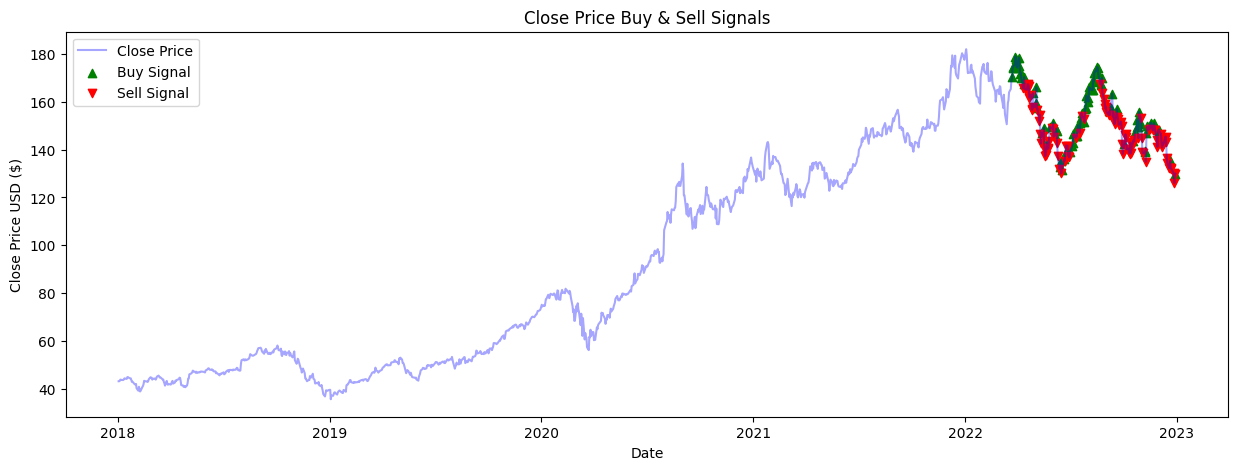

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert index to datetime for plotting
df.index = pd.to_datetime(df.index)

true_future_price = df['Close'].iloc[-len(X_test):]

buy_signals = true_future_price[signals]
sell_signals = true_future_price[np.logical_not(signals)]


plt.figure(figsize=(15,5))
plt.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.35)
plt.scatter(buy_signals.index, buy_signals, color='green', label='Buy Signal', marker='^', alpha=1)
plt.scatter(sell_signals.index, sell_signals, color='red', label='Sell Signal', marker='v', alpha=1)
plt.title('Close Price Buy & Sell Signals')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()
